In [19]:
import sys
import os
path = os.path.abspath("../")
sys.path.append(path)
print(path)

/home/jovyan


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random


import src.helpers.MetricUtilities as metrics
import src.data_processing.ImageProducts as ImageProducts
from src.data_processing.DatasetGetter import get_data, get_data_MStar, get_data_SARDet_100k

from mtree.mtree import MTree
import mtree.mtree as mtree

import glob
from PIL import Image

import time
import json
import xml.etree.ElementTree as ET

from id_estimator.PackingDimension import packing_dim

In [4]:
import statistics

def packing_dim(r_1, r_2, epsilon, testSample, d):
    l = 1
    L_1 = []
    L_2 = []
    while True:
        S_n = np.random.permutation(testSample)
        C = []
        for i in range(len(S_n)):
            badPoint = False
            for j in range(len(C)):
                if (d(S_n[i], C[j]) < r_1):
                    # print(d(S_n[i], C[j]))
                    badPoint = True
            if (not badPoint):
                # print("not badpoint")
                C.append(S_n[i])
        L_1.append(math.log(len(C)))
        # print(f"L1: {L_1}")
        C = []
        for i in range(len(testSample)):
            badPoint = False
            for j in range(len(C)):
                if (d(S_n[i], C[j]) < r_2):
                    badPoint = True
            if (not badPoint):
                # print("not badpoint")
                C.append(S_n[i])
                # print(f"C: {C}")
        L_2.append(math.log(len(C)))
        # print(f"L2: {L_2}")
        
        num = (np.sum(L_1) / len(L_1)) - (np.sum(L_2) / len(L_2))
        dem = math.log(r_2) - math.log(r_1)
        if (num == 0):
            D_pack = 0
        else:
            D_pack = num / dem
        # D_pack = num / ()
        # print(f"l: {l} and D_pack: {D_pack}")
        if (l > 10):
            # print("l > 10 now")
            numerator = math.sqrt(statistics.variance(L_1) + statistics.variance(L_2))
            denom = math.sqrt(l) * (math.log(r_2) - math.log(r_1))
            # print(numerator / denom)
            if (1.65 * (numerator / denom) < D_pack * (1-epsilon) / 2):
                return D_pack
        l += 1


In [5]:
list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_all.npz"

data = np.load(list_data)
all_data = data["testSample"]

In [8]:
import random

# sample_indices = np.array(random.sample(range(len(all_data), 10)))
sample_indices = np.array(random.sample(range(len(all_data)), 100))
# print(sample_indices)
# sample_indices = np.array(random.sample(range(len(entry)), left_len))
testSample = all_data[sample_indices]
# print(testSample.shape)

In [21]:
import random
IMDB_WIKI_data = get_data(128)
sample_indices = random.sample(range(len(IMDB_WIKI_data)), 100)
sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

testSample = np.array(sampled_test_data)

In [17]:
import random
data = get_data_MStar(128)
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = np.array([item[0] for item in sampled_test_data])

In [14]:
import random
data = get_data_SARDet_100k(128)
sample_indices = random.sample(range(len(data)), 100)
sampled_test_data = Subset(data, sample_indices)

testSample = np.array([item[0] for item in sampled_test_data])

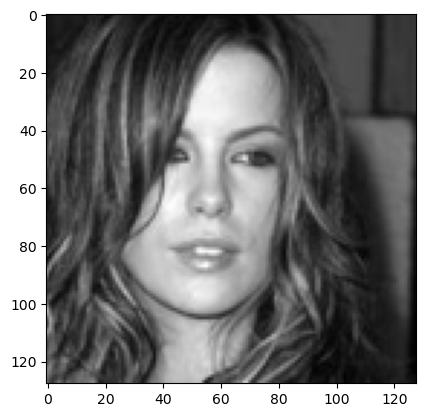

In [22]:
data = testSample[50]

plt.imshow(data, cmap="gray")
plt.show()

In [134]:
r_1 = 0.1
r_2 = 0.15
epsilon = 0.01

D_pack = packing_dim(r_1, r_2, epsilon, testSample, metrics.dist_fft_numba)
print(D_pack)

# these are r = 0.1m r2 = 0.2 or r=0.01, r2= 0.02 i forgot, epsilon 0.5
# r=0.1 r2=0.2 works...
# For ATRNET 100 its 3.4 in 19s
# For IMDB its 0.18 omg IT CORRELATES!!! in 1m
# For MStar its 0.99 oh thats cool! in 32s
# For SARDET its 0.60 oh funsies. in 24s
# Ok it all actl correlates perfectly lovelyyyy
# Mayb I shld j download random ass datasets to try

# epsilon = 0.01... seems a bit sus. I think epsilon should be 0.99 for 99% accuracy instead thats why its taking such a short while OH WAIT nvm 0.01 is correct
# these results are so wrong TT
# for IMDB w average distancing r and epsilon 0.01... r1=0.35519913309165985, r2= r1 / 2,  ss=100, 2.06670927032519
# for MSTAR w average distancing r and epsilon 0.01... r1=0.2874618664410695, r2= r1 / 2,  ss=100, 0.924799078470416
# for SARDET w average distancing r and epsilon 0.01... r1=0.27816828240437047, r2= r1 / 2,  ss=100, 1.1172678641872351
# for ATRNET w average distancing r and epsilon 0.01... r1=0.11801859617485709, r2= r1 / 2,  ss=100, 1.4447639205568288


# IMDB epsilon=0.95, 0.3762601202257626, 3.2288575970384
# MSTAR 0.245971864754331, 1.1003957200143155
# SARDET 0.23582069057274893, 0.6553306229013383
# ATRNET 0.11826122486459371, 1.6479560136159335

# IMDB epsilon = 0.01, r1=0.366688015469522 again ss=100

# for IMDB 100 r1=0.2, r2=0.3, epsilon=0.01, 1.9178145789982848
# for ATRNET 100 r1=0.2, r2=0.3, epsilon=0.01, 2.709511291351456

# I should plot w consectuive values of a sequence of r plotted at halfway or smt like that... maybs the rs can be 0.05, 0.1, 0.15, 0.2, 0.25, 0.3

# for ATRNET 100 epsilon=0.01,???????????
# r_1=0.05, r_2=0.1 0.7951654750241648
# r_1=0.1, r_2=0.15 2.396874022214933
# r_1=0.15, r_2=0.2 3.8137837643096293
# r_1=0.2, r_2=0.25 7.1641061097411445
# r_1=0.25, r_2=0.3 3.860512940065676

# for IMDB 100 epsilon=0.01
# r_1=0.05, r_2=0.1 
# r_1=0.1, r_2=0.15 0.15505280747294337
# r_1=0.15, r_2=0.2 0.40399419654591423 
# r_1=0.2, r_2=0.25 1.0072751096835382
# r_1=0.25, r_2=0.3 2.4780407589364066


# for MSTAR 100 epsilon=0.01
# r_1=0.05, r_2=0.1 0.5007867959837168
# r_1=0.1, r_2=0.15 1.314569042515671
# r_1=0.15, r_2=0.2 1.290879923879451
# r_1=0.2, r_2=0.25 1.216679397667675
# r_1=0.25, r_2=0.3 1.3346942111177769

# for SARDET 100 epsilon=0.01
# r_1=0.05, r_2=0.1 0.6030105757858368
# r_1=0.1, r_2=0.15 0.5453030568753482
# r_1=0.15, r_2=0.2 0.3464960067694197
# r_1=0.2, r_2=0.25 0.4718318123282027
# r_1=0.25, r_2=0.3 1.0463287258879066

0.06369512139380737


In [ ]:
def calc_packings_imdb(r1, r2, epsilon):
    IMDB_WIKI_data = get_data(128)
    sample_indices = random.sample(range(len(IMDB_WIKI_data)), 100)
    sampled_test_data = Subset(IMDB_WIKI_data, sample_indices)

    testSample = np.array(sampled_test_data)

    return packing_dim(r1, r2, epsilon, testSample, metrics.dist_fft_numba)

def calc_packings_MSTAR(r1,r2,epsilon):
    data = get_data_MStar(128)
    sample_indices = random.sample(range(len(data)), 100)
    sampled_test_data = Subset(data, sample_indices)

    testSample = np.array([item[0] for item in sampled_test_data])

    return packing_dim(r1, r2, epsilon, testSample, metrics.dist_fft_numba)

def calc_packings_SARDET(r1,r2,epsilon):
    data = get_data_SARDet_100k(128)
    sample_indices = random.sample(range(len(data)), 100)
    sampled_test_data = Subset(data, sample_indices)

    testSample = np.array([item[0] for item in sampled_test_data])
    
    return packing_dim(r1, r2, epsilon, testSample, metrics.dist_fft_numba)

def calc_packings_ATRNET(r1,r2,epsilon):
    list_data = "/home/jovyan/data/ATRNet-STAR_annotations/list_data_all.npz"
    data = np.load(list_data)
    all_data = data["testSample"]
    sample_indices = np.array(random.sample(range(len(all_data)), 100))
    testSample = all_data[sample_indices]
    
    return packing_dim(r1, r2, epsilon, testSample, metrics.dist_fft_numba)

In [ ]:
def calc_packings(r=[], epsilon=0.01, runs=5, filename=""):
    avgs_ATRNET = []
    avgs_IMDB = []
    avgs_MSTAR = []
    avgs_SARDET = []

    for i in range(1, len(r)):
        avg_ATRNET = 0
        avg_IMDB = 0
        avg_MSTAR = 0
        avg_SARDET = 0
        for j in range(runs):
            avg_ATRNET += calc_packings_ATRNET(r[i-1],r[i],epsilon)
            avg_IMDB += calc_packings_imdb(r[i-1],r[i],epsilon)
            avg_MSTAR += calc_packings_MSTAR(r[i-1],r[i],epsilon)
            avg_SARDET += calc_packings_SARDET(r[i-1],r[i],epsilon)

        avg_ATRNET = avg_ATRNET / runs
        avg_IMDB = avg_IMDB / runs
        avg_MSTAR = avg_MSTAR / runs
        avg_SARDET = avg_SARDET / runs

        avgs_ATRNET.append(avg_ATRNET)
        avgs_IMDB.append(avg_IMDB)
        avgs_MSTAR.append(avg_MSTAR)
        avgs_SARDET.append(avg_SARDET)
    
    print(f"ATRNET: {avgs_ATRNET}")
    print(f"IMDB: {avgs_IMDB}")
    print(f"MSTAR: {avgs_MSTAR}")
    print(f"SARDET: {avgs_SARDET}")

    with open(filename, "w") as f:
        f.write(f"r: {r}\n")
        f.write(f"ATRNET: {avgs_ATRNET}\n")
        f.write(f"IMDB: {avgs_IMDB}\n")
        f.write(f"MSTAR: {avgs_MSTAR}\n")
        f.write(f"SARDET: {avgs_SARDET}")


In [ ]:
r_1 = 0.25
r_2 = 0.3
epsilon = 0.01

D_pack = packing_dim(r_1, r_2, epsilon, testSample, metrics.dist_fft_numba)
print(D_pack)

# these are r = 0.1m r2 = 0.2 or r=0.01, r2= 0.02 i forgot, epsilon 0.5
# r=0.1 r2=0.2 works...
# For ATRNET 100 its 3.4 in 19s
# For IMDB its 0.18 omg IT CORRELATES!!! in 1m
# For MStar its 0.99 oh thats cool! in 32s
# For SARDET its 0.60 oh funsies. in 24s
# Ok it all actl correlates perfectly lovelyyyy
# Mayb I shld j download random ass datasets to try

# epsilon = 0.01... seems a bit sus. I think epsilon should be 0.99 for 99% accuracy instead thats why its taking such a short while OH WAIT nvm 0.01 is correct
# these results are so wrong TT
# for IMDB w average distancing r and epsilon 0.01... r1=0.35519913309165985, r2= r1 / 2,  ss=100, 2.06670927032519
# for MSTAR w average distancing r and epsilon 0.01... r1=0.2874618664410695, r2= r1 / 2,  ss=100, 0.924799078470416
# for SARDET w average distancing r and epsilon 0.01... r1=0.27816828240437047, r2= r1 / 2,  ss=100, 1.1172678641872351
# for ATRNET w average distancing r and epsilon 0.01... r1=0.11801859617485709, r2= r1 / 2,  ss=100, 1.4447639205568288


# IMDB epsilon=0.95, 0.3762601202257626, 3.2288575970384
# MSTAR 0.245971864754331, 1.1003957200143155
# SARDET 0.23582069057274893, 0.6553306229013383
# ATRNET 0.11826122486459371, 1.6479560136159335

# IMDB epsilon = 0.01, r1=0.366688015469522 again ss=100

# for IMDB 100 r1=0.2, r2=0.3, epsilon=0.01, 1.9178145789982848
# for ATRNET 100 r1=0.2, r2=0.3, epsilon=0.01, 2.709511291351456

# I should plot w consectuive values of a sequence of r plotted at halfway or smt like that... maybs the rs can be 0.05, 0.1, 0.15, 0.2, 0.25, 0.3

# for ATRNET 100 epsilon=0.01,???????????
# r_1=0.05, r_2=0.1 0.7951654750241648
# r_1=0.1, r_2=0.15 2.396874022214933
# r_1=0.15, r_2=0.2 3.8137837643096293
# r_1=0.2, r_2=0.25 7.1641061097411445
# r_1=0.25, r_2=0.3 0.7361277852123475

# for IMDB 100 epsilon=0.01
# r_1=0.05, r_2=0.1 
# r_1=0.1, r_2=0.15 0.15505280747294337
# r_1=0.15, r_2=0.2 0.40399419654591423 
# r_1=0.2, r_2=0.25 1.0072751096835382
# r_1=0.25, r_2=0.3 


# for MSTAR 100 epsilon=0.01
# r_1=0.05, r_2=0.1 
# r_1=0.1, r_2=0.15 
# r_1=0.15, r_2=0.2 
# r_1=0.2, r_2=0.25 
# r_1=0.25, r_2=0.3 

# for SARDET 100 epsilon=0.01
# r_1=0.05, r_2=0.1 
# r_1=0.1, r_2=0.15 
# r_1=0.15, r_2=0.2 
# r_1=0.2, r_2=0.25 
# r_1=0.25, r_2=0.3 

2.4780407589364066
